In [1]:
import torch
import numpy as np
import pandas as pd
import random
from models_A import preprocessing_from_matlab
from scipy.io.matlab import loadmat
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
from models_A import ModelA, ModelAN
from seaborn import set_theme

plt.style.use("duarte.mplstyle")
%matplotlib widget

In [2]:
states_mat = loadmat("../../../../xs_all.mat")
forces_mat = loadmat("../../../../tau_all.mat")

In [3]:
pd.DataFrame(forces_mat["tau_all"][5][0].T)

,0,1,2,3
0,21.582000,0.000000,0.000000,0.000000e+00
1,28.842000,0.000000,0.000000,-2.500000e-01
2,28.842000,-0.005078,0.202376,-2.500000e-01
3,28.812944,-0.005113,0.202229,-2.489069e-01
4,28.783856,-0.005106,0.179201,-2.477922e-01
...,...,...,...,...
19996,21.584105,-0.000052,0.000027,-8.446522e-07
19997,21.584105,-0.000052,0.000027,-8.434733e-07
19998,21.584105,-0.000052,0.000027,-8.422910e-07
19999,21.584105,-0.000052,0.000027,-8.411053e-07


In [4]:
random_force_denorm = forces_mat["tau_all"][1][0].T
pd.DataFrame(random_force_denorm)

,0,1,2,3
0,21.582000,0.000000,0.000000,0.000000e+00
1,28.842000,0.000000,0.000000,-2.500000e-01
2,28.842000,-0.004924,0.199724,-2.500000e-01
3,28.812944,-0.004960,0.199578,-2.489069e-01
4,28.783856,-0.004954,0.176850,-2.477922e-01
...,...,...,...,...
19996,21.584105,-0.000052,0.000027,-8.446522e-07
19997,21.584105,-0.000052,0.000027,-8.434733e-07
19998,21.584105,-0.000052,0.000027,-8.422910e-07
19999,21.584105,-0.000052,0.000027,-8.411053e-07


In [5]:
states, states_norms = preprocessing_from_matlab(states_mat)
forces, forces_norms = preprocessing_from_matlab(forces_mat)

In [6]:
random_state, random_state_norm = states[900], states_norms[900]
random_force, random_force_norm = forces[900], forces_norms[900]

In [7]:
model = ModelA()
model.load_state_dict(torch.load("model.pt"))
model_norms = ModelAN()
model_norms.load_state_dict(torch.load("model_norms.pt"))

<All keys matched successfully>

In [8]:
model.eval()
with torch.inference_mode():
    normalized_forces = model(torch.tensor(random_state, dtype=torch.float32))

In [9]:
model_norms.eval()
with torch.inference_mode():
    forces_norms = model_norms(torch.tensor(random_state_norm, dtype=torch.float32))

In [10]:
forces = []
for i in range(normalized_forces.shape[-1]):
    force_denorm = normalized_forces[:,i]*forces_norms[i]
    force_denorm = force_denorm.numpy()
    forces.append(force_denorm)
forces = np.array(forces).T

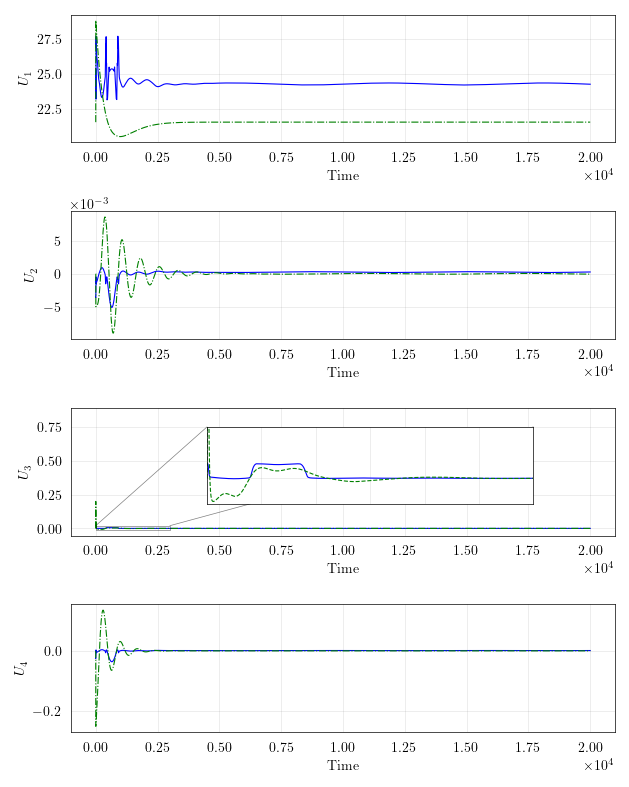

In [13]:
t = np.arange(0,20001,1)

cm=1/2.54
fig, axs = plt.subplots(4,1, figsize=(16*cm,20*cm))
for i, ax in enumerate(axs.flatten()):
    if i == 2:
        x1, x2, y1, y2 = 0, 3000, -0.01, 0.02  # subregion of the original image
        axins = ax.inset_axes([0.25, 0.25, 0.6, 0.6],xlim=(x1, x2), ylim=(y1,y2), xticklabels=[], yticklabels=[])
        axins.plot(t, forces[:,i])
        axins.plot(t, random_force_denorm[:,i])
        ax.indicate_inset_zoom(axins, edgecolor="black")
    # ax.set_xlim(-100,5000)
    ax.plot(t, forces[:,i], label="Pred")
    ax.plot(t, random_force_denorm[:,i], label="Real", ls="-.")
    ax.set_xlabel("Time")
    ax.set_ylabel(f"$U_{i+1}$")
    # ax.ticklabel_format(style="sci",
    #                     scilimits=(0,0),
    #                     useMathText=True,
    #                     axis="x")
    # ax.legend()

fig.tight_layout()
fig.savefig("../../../report/figures/4results/uav/forces_denormalized.pdf")